In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
import os
from scipy import signal
from scipy.signal import savgol_filter
from scipy.signal import lfilter
from statistics import mean

# There is an example of running the entire process at the bottom of this notebook

In [2]:
#first test
waterflowData = pd.read_csv(os.getcwd() + "/data/WaterFlowTest_08_08_16_42")
tankData = waterflowData['low2'].to_numpy()
amountOfData = len(tankData)
currPressureData = np.asarray([0] * amountOfData)

# #second test
# waterflowData2 = pd.read_csv(os.getcwd() + "/data/waterflow_test_full_9_5_16_16")
# tankData2 = waterflowData2['low1'].to_numpy()
# amountOfData2 = len(tankData2)
# currPressureData2 = np.asarray([0] * amountOfData2)

# #third test
# waterflowData3 = pd.read_csv(os.getcwd() + "/data/waterflow_test_full_9_5_14_31 (1)")
# tankData3 = waterflowData3['low1'].to_numpy()
# amountOfData3 = len(tankData3)
# currPressureData3 = np.asarray([0] * amountOfData3)

FileNotFoundError: [Errno 2] File /home/vamshibalanaga/Documents/SEB/Ground-Station/DataMonitoring/data/waterflow_test_full_9_5_16_16 does not exist: '/home/vamshibalanaga/Documents/SEB/Ground-Station/DataMonitoring/data/waterflow_test_full_9_5_16_16'

In [ ]:
#sixth test

waterflowData6 = pd.read_csv(os.getcwd() + "/data/waterflow_09-26-20__15_17.csv")
time = waterflowData6["time"].to_numpy()
high= waterflowData6["high"].to_numpy()
lox_tank=waterflowData6["loxtank"].to_numpy()
propane_tank=waterflowData6["propanetank"].to_numpy()
lox_injector=waterflowData6["loxinjector"].to_numpy()
propane_injector=waterflowData6["propaneinjector"].to_numpy()


In [11]:
##function for creating separate arrays for each column in data file 
def create_data(data_file):
    waterflowData = pd.read_csv(os.getcwd() + "/data/"+ data_file)
    cols = waterflowData.columns.to_numpy()
    time = waterflowData[cols[0]].to_numpy() # time
    high= waterflowData[cols[1]].to_numpy()  # high pt
    lox_tank=waterflowData[cols[2]].to_numpy() # lox tank
    propane_tank=waterflowData[cols[3]].to_numpy()  # propane tank
    lox_injector=waterflowData[cols[4]].to_numpy()  # lox injector
    propane_injector=waterflowData[cols[5]].to_numpy()  # propane injector
    return time, high, lox_tank, propane_tank, lox_injector, propane_injector

In [64]:
def display_pressure(time, data, peaks):
    xaxis = np.arange(len(data))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,5))
    ax1.set_ylabel("Pressure (psi)")
    ax1.plot(xaxis, data)
    ax1.set_xlabel("index")
    ax2.plot(time, data)
    ax2.set_xlabel("time (s)")
    
    print(peaks)
    for i in peaks:
        for x in i:
            ax1.axvline(x,c='k', lw='1')
            ax2.axvline(time[x], c='k', lw='1')
    plt.show()
    

In [ ]:
test6_time, test6_high, test6_lox_tank, test6_propane_tank, test6_lox_injector, test6_propane_injector=create_data("waterflow_09-26-20__15_17.csv")


In [61]:
##current version of detect function
##added third "zoom-in" without dary data 
def detectPeaks(data):
    time = data[0]
    pdata = data[1]
    xaxis = np.arange(0,len(pdata),1)
    print("Amount of Data Points:", len(pdata))
    n = 100  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data2 = lfilter(b,a,pdata)
    dary = np.array([*map(float, pdata)])
    dary -=np.average(dary)
    step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))

    dary_step = np.convolve(dary, step, mode='valid')
    peaksall=[]
    peaks = signal.find_peaks(dary_step, width=20)[0]
    print("trying it out:", peaks)
    if len(peaks)>0:
        for p in peaks:
            
            peaksall.append(np.array([p]))
    print("Positive Peaks:", len(peaks))
    peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print("Negative Peaks:", len(peaks2))
    if len(peaks2)>0:
        for p in peaks2:
            
            peaksall.append(np.array([p]))
    print("Total Peaks detected:", len(peaksall))
    print(peaksall)
    plt.figure()

    plt.plot(dary)

    plt.plot(dary_step/10)

    for ii in range(len(peaks)):
        plt.plot((peaks[ii], peaks[ii]), (-1500, 1500), 'r')

    plt.show()
    ##start of second round
    #creating new data set with first and last peak as lower, upper bounds
    if len(peaksall)>=2:
        data2 = pdata[int(peaksall[0][0]):int(peaksall[-1][-1])]
    else:
        data2 = pdata[0:int(peaksall[-1])]
    ##
    n = 5  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data = lfilter(b,a,data2)
    ##
    dary2 = np.array([*map(float, data2)])
    
    dary2 -=np.average(dary2)
    step2 = np.hstack((np.ones(len(dary2)), -1*np.ones(len(dary2))))

    dary_step2 = np.convolve(dary2, step2, mode='valid')

    # Get the peaks of the convolution
    #negative peaks
    peaks3 = signal.find_peaks(-dary_step2, width=20)[0]
    #positive peaks
    peaks4 = signal.find_peaks(dary_step2, width=20)[0]
    #adjusting for frame shift
    if len(peaksall)>=2:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]+peaks[0]+1]))
            #peaksall.append(peaks3+peaks+1)
        print("Negative Peaks Detected:", len(peaks3), "at", peaks3)
        if len(peaks4)>0:
            for p in range(len(peaks4)):
                peaksall.append(np.array([peaks4[p]+peaks[0]+1]))
            #peaksall.append(peaks4+peaks+1)
        print("Positive Peaks Detected:", len(peaks4), "at", peaks4)
        print(peaksall)
    else:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]]))
        print("Negative Peaks Detected:", len(peaks3),"at",peaks3)
        if len(peaks4)>0:
            for p in peaks4:
                
                peaksall.append(np.array([p]))
        print("Positive Peaks Detected:", len(peaks4),"at", peaks4)
        print(peaksall)
    ###make this more robust
    #peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print(peaks3)

    # plots
    plt.figure()

    plt.plot(dary2)
    #orange:
    plt.plot(dary_step2/10)
    #repeat process on dary data:
    n = 20  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data3 = lfilter(b,a,dary_step2/10)
    peaks40 = signal.find_peaks(filter_data3, width=20)[0]
    peaks30 = signal.find_peaks(-filter_data3, width=20)[0]
    peaksall2=[]
    plt.plot(filter_data3)
    for ii in range(len(peaks40)):
        plt.plot((peaks40[ii], peaks40[ii]), (-150, 150), 'green')
    ##adding to master graph
    if len(peaksall)>=2:
        if len(peaks30)>0:
            for p in range(len(peaks30)):
                print("testing peaks:",peaks)
                print("testing peaks30:", peaks30)
                peaksall2.append(np.array([peaks30[p]+peaks[p]+1]))
                print("testing something:", np.array([peaks30[p]+peaks[p]+1]))
            #peaksall2.append(peaks30+peaks+1)
        print("Negative Peaks Detected:", len(peaks30), "at", peaks30)
        if len(peaks40)>0:
            for p in range(len(peaks40)):
                peaksall2.append(np.array([peaks40[p]+peaks[p]+1]))
            #peaksall2.append(peaks40+peaks+1)
        print("Positive Peaks Detected:", len(peaks40), "at", peaks40)
        print("This is peaksall2:",peaksall2)
    else:
        if len(peaks30)>0:
            for p in peaks30:
                peaksall2.append(np.array([p]))
            #peaksall2.append(peaks30)
        print("Negative Peaks Detected:", len(peaks30),"at",peaks30)
        if len(peaks40)>0:
            for p in peaks40:
                peaksall.append(np.array([p]))
            #peaksall2.append(peaks40)
        print("Positive Peaks Detected:", len(peaks40),"at", peaks40)
        print(peaksall2)
    ## appending 2nd round of lines to first
    
    peaksall = peaksall + peaksall2
    print("This is peaksall:", peaksall)
    peaksall.sort()
    
        
    for ii in range(len(peaks3)):
        plt.plot((peaks3[ii], peaks3[ii]), (-150, 150), 'r')

    plt.show()
    
    ##end of second round
    print("end of second round")
    
    ##start of third round
    #creating new data set with first and last peak as lower, upper bounds
    if len(peaksall)>=2:
        data2 = pdata[int(peaksall[0][0]):int(peaksall[2][-1])]
    else:
        data2 = pdata[0:int(peaksall[-1])]
    ##
    n = 5  # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    filter_data4 = lfilter(b,a,data2)
    ##
    dary2 = np.array([*map(float, filter_data4)])
    
    dary2 -=np.average(dary2)
    step2 = np.hstack((np.ones(len(dary2)), -1*np.ones(len(dary2))))

    dary_step2 = np.convolve(dary2, step2, mode='valid')

    # Get the peaks of the convolution
    #negative peaks
    peaks3 = signal.find_peaks(-dary_step2, width=20)[0]
    #positive peaks
    peaks4 = signal.find_peaks(dary_step2, width=20)[0]
    #adjusting for frame shift
    if len(peaksall)>=2:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]+peaks[0]+1]))
            #peaksall.append(peaks3+peaks+1)
        print("Negative Peaks Detected:", len(peaks3), "at", peaks3)
        if len(peaks4)>0:
            for p in range(len(peaks4)):
                peaksall.append(np.array([peaks4[p]+peaks[0]+1]))
            #peaksall.append(peaks4+peaks+1)
        print("Positive Peaks Detected:", len(peaks4), "at", peaks4)
        print(peaksall)
    else:
        if len(peaks3)>0:
            for p in range(len(peaks3)):
                peaksall.append(np.array([peaks3[p]]))
        print("Negative Peaks Detected:", len(peaks3),"at",peaks3)
        if len(peaks4)>0:
            for p in peaks4:
                
                peaksall.append(np.array([p]))
        print("Positive Peaks Detected:", len(peaks4),"at", peaks4)
        print(peaksall)
    ###make this more robust
    #peaks2 = signal.find_peaks(-dary_step, width=20)[0]
    print(peaks3)

    # plots
    plt.figure()

    plt.plot(dary2)
    #orange:
    plt.plot(dary_step2/10)
    
    peaksall.sort()
    
        
    for ii in range(len(peaks3)):
        plt.plot((peaks3[ii], peaks3[ii]), (-150, 150), 'r')

    plt.show()
    
    ##end of third round
    print("end of third round")
    

    display_pressure(time, pdata, peaksall)
    #for i in peaksall2:
        #for x in i:
            #plt.axvline(x,c='green', lw='1')
    plt.show()
    
    return [time,pdata,peaksall]

In [69]:
##function for adding lines
def add_lines(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    xaxis = np.arange(0,len(data),1)
    plt.figure(dpi=100, figsize=(20,5))
    plt.plot(xaxis, data)
    
    print(peaksall)
    for i in peaksall:
        for x in i:
            plt.axvline(x,c='k', lw='1')
    
    plt.show()
    
    ##adding new lines with user input
    
    user_input3 = input("List of lines to add, by approximate X axis value (can edit later for precision):")
    
    if user_input3:
        new_lines =  list(map(int,user_input3.split(',')))
        
        for i in new_lines:
            peaksall.append(np.array([i]))
        
#         peaksall.sort()
#         plt.figure(dpi=100, figsize=(20,5))
#         plt.plot(xaxis, data)

#         print(peaksall)
#         for i in peaksall:
#             for x in i:
#                 plt.axvline(x,c='k', lw='1')
    
        display_pressure(time, data ,peaksall)

        plt.show()
    
    
    return [time, data, peaksall]
    

In [70]:
##function for editing lines
def edit_lines(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    xaxis = np.arange(0,len(data),1)
    plt.figure(dpi=100, figsize=(20,5))
    plt.plot(xaxis, data)
    
    print(peaksall)
    for i in peaksall:
        for x in i:
            plt.axvline(x,c='k', lw='1')
    
    plt.show()
    
    ###shifting lines with user input
    
    user_input2 = input("List of lines to edit, separated by comma (starting at index 0), e.g. 0,2,5: ") 
    
    if user_input2:
        b_list =  list(map(int,user_input2.split(',')))
    
    for i in b_list:
        
        print("Y axis value", "Corresponding Pressure")
        print(peaksall[i]-5, data[int(peaksall[i]-5)])
        print(peaksall[i]-4, data[int(peaksall[i]-4)])
        print(peaksall[i]-3, data[int(peaksall[i]-3)])
        print(peaksall[i]-2, data[int(peaksall[i]-2)])
        print(peaksall[i]-1, data[int(peaksall[i]-1)])
        print("Current Line:")
        print(peaksall[i], data[int(peaksall[i])])
        print(peaksall[i]+1, data[int(peaksall[i]+1)])
        print(peaksall[i]+2, data[int(peaksall[i]+2)])
        print(peaksall[i]+3, data[int(peaksall[i]+3)])
        print(peaksall[i]+4, data[int(peaksall[i]+4)])
        print(peaksall[i]+5, data[int(peaksall[i]+5)])
        
        user_input3 = input("Choose X value for new line or type 0 to delete")
        
        del peaksall[i]
        if user_input3!=0:
        
            peaksall.insert(i, np.array([int(user_input3)]))
    
    
    
#     plt.figure(dpi=100, figsize=(20,5))
#     plt.plot(xaxis, data)

#     print(peaksall)
#     for i in peaksall:
#         for x in i:
#             plt.axvline(x,c='k', lw='1')


#     plt.show()
    display_pressure(time, data, peaksall)
    peaksall.sort()
    return [time, data, peaksall]
    

In [72]:
##function for removing lines
def remove_lines(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    
    data = detect_data[1]
    time = detect_data[0]
    
    xaxis = np.arange(0,len(data),1)
    plt.figure(dpi=100, figsize=(20,5))
    plt.plot(xaxis, data)
    
    print(peaksall)
    for i in peaksall:
        for x in i:
            plt.axvline(x,c='k', lw='1')
    
    plt.show()
    
    ##taking user input and removing lines
    user_input = input("List of lines to remove, separated by comma (starting at index 0), e.g. 0,2,5: ")
    
    if user_input:
        a_list =  list(map(int,user_input.split(',')))
        print(a_list)
        print(peaksall)

        #removing lines at index indicated by user input, using inserts to maintain list length in process
        for i in a_list:
            del peaksall[i]
            peaksall.insert(i,np.array([69.69]))
        print("dfahkdfakhdf", peaksall)

        #removing the replaced items in peaksall
        peaksall = [x for x in peaksall if x!=([69.69])]
        #peaksall = [x  for x in range(len(peaksall)) if not peaksall[a_list[x]]]

        display_pressure(time, data, peaksall)
        
        return [time, data, peaksall]

In [80]:
##function for returning values
def values(detect_data):
    ##plotting input data
    ##data[0] = pressure data
    ##data[1] = array of detected peaks
    peaksall = detect_data[2]
    data = detect_data[1]
    time = detect_data[0]
    xaxis = np.arange(0,len(data),1)
    
    display_pressure(time, data, peaksall)
    
    ##taking input on data type and returning parameters according to data type
    ##can probably be done with radios in gui
    data_type = input("Data Type (high, propane injector, propane tank, lox injector, or lox tank)")
    
    if data_type=="propane tank" or "lox tank":
        
        static_condition = data[int(peaksall[0]):int(peaksall[1])]
        static_pressure = mean(static_condition)
        print("Static Pressure:", static_pressure)
        dynamic_condition = data[int(peaksall[1]):int(peaksall[2])]
        dynamic_pressure = mean(dynamic_condition)
        print("Dynamic Pressure:", dynamic_pressure)
        droop = static_pressure - dynamic_pressure 
        print("Droop:", droop)
        emptying_time = int(peaksall[3])-int(peaksall[1])
        print("Emptying Time:", emptying_time)
        dynamic_rate_of_increase = (data[int(peaksall[3])]-data[int(peaksall[2])])/emptying_time
        print("Dyanmic Rate of Increase:", dynamic_rate_of_increase)
        return static_pressure, dynamic_pressure, droop, emptying_time, dynamic_rate_of_increase
    elif data_type=="propane injector" or "lox injector":
        
        dynamic_condition = data[int(peaksall[0]):int(peaksall[1])]
        dynamic_pressure = mean(dynamic_condition)
        print("Dynamic Pressure:", dynamic_pressure)
        emptying_time = int(peaksall[1])-int(peaksall[0])
        print("Emptying Time:", emptying_time)
        return dynamic_pressure, emptying_time
        
    
    elif data_type=="high":
        print("high")
    else:
        ##implement a better way to do this
        print("try again")
        values(detect_data)
     

# Example of entire process:

Using function "create_data" with input "waterflow_10-03-20__20_46.csv" to create 6 arrays for 6 columns in data file:

In [19]:
time, high, lox_tank, propane_tank, lox_injector, propane_injector = create_data("waterflow_10-03-20__20_46.csv")

Slicing propane tank data to extract useful section:

[]


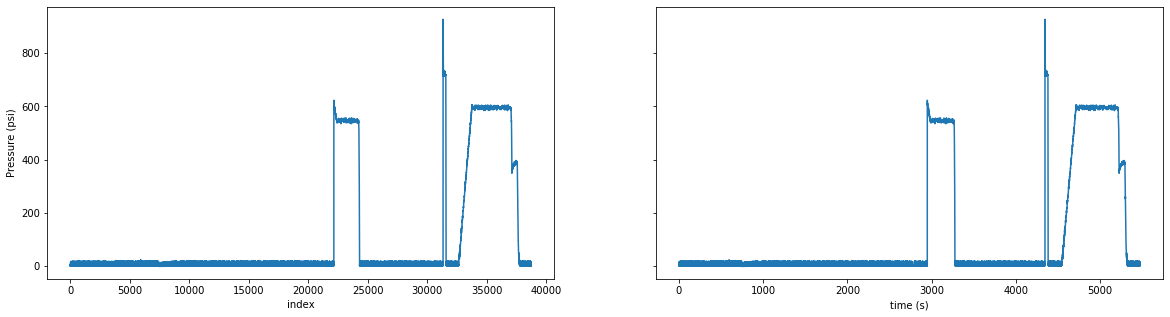

In [66]:
display_pressure(time, propane_tank, [])

In [67]:
index_start = 32000
index_end = 39000
processed_tank_data = np.array([time[index_start:index_end], propane_tank[index_start:index_end]])

Using function "detectPeaks" with pressure data input to return a list of the form [(inputted data), (array of X-axis values for detected peaks)]. The variable "testdata" in this case can then be passed into any of the subsequent functions for manipulating the peaks/lines.

Amount of Data Points: 6727
trying it out: [1317 5208]
Positive Peaks: 2
Negative Peaks: 2
Total Peaks detected: 4
[array([1317]), array([5208]), array([5095]), array([5552])]


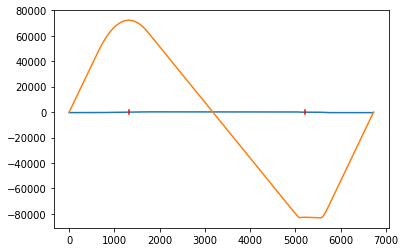

Negative Peaks Detected: 1 at [3724]
Positive Peaks Detected: 1 at [350]
[array([1317]), array([5208]), array([5095]), array([5552]), array([5042]), array([1668])]
[3724]
testing peaks: [1317 5208]
testing peaks30: [3734]
testing something: [5052]
Negative Peaks Detected: 1 at [3734]
Positive Peaks Detected: 1 at [358]
This is peaksall2: [array([5052]), array([1676])]
This is peaksall: [array([1317]), array([5208]), array([5095]), array([5552]), array([5042]), array([1668]), array([5052]), array([1676])]


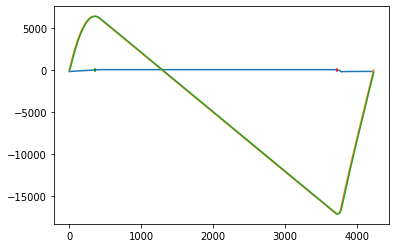

end of second round
Negative Peaks Detected: 0 at []
Positive Peaks Detected: 1 at [175]
[array([1317]), array([1668]), array([1676]), array([5042]), array([5052]), array([5095]), array([5208]), array([5552]), array([1493])]
[]


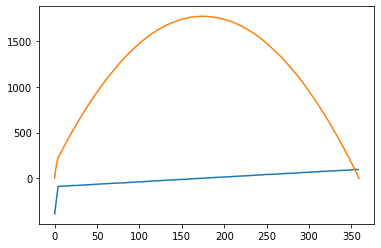

end of third round
[array([1317]), array([1493]), array([1668]), array([1676]), array([5042]), array([5052]), array([5095]), array([5208]), array([5552])]


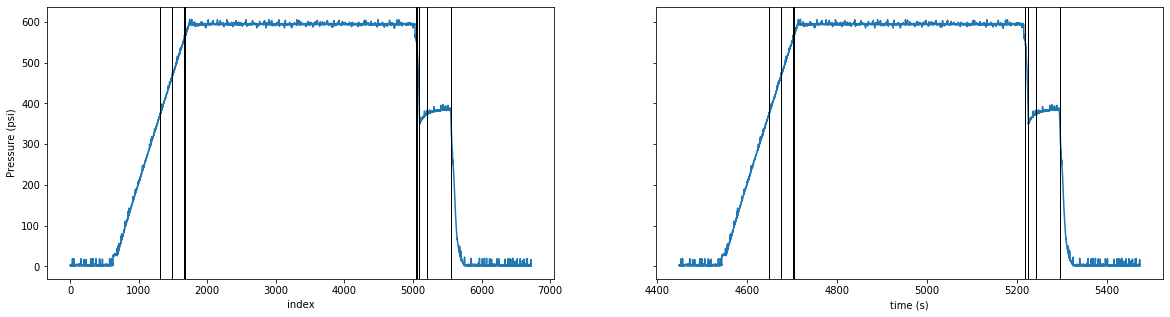

In [68]:
processed_tank_data = detectPeaks(processed_tank_data)

Using function "remove_lines" with testdata input (list with raw data and list of peaks) to remove lines based on user input.  This returns a list of the same format as its input, with changes reflecting user input.  This can be run as many times as you want as long as variables are assigned properly.

[array([1676]), array([5052]), array([5095]), array([5552])]


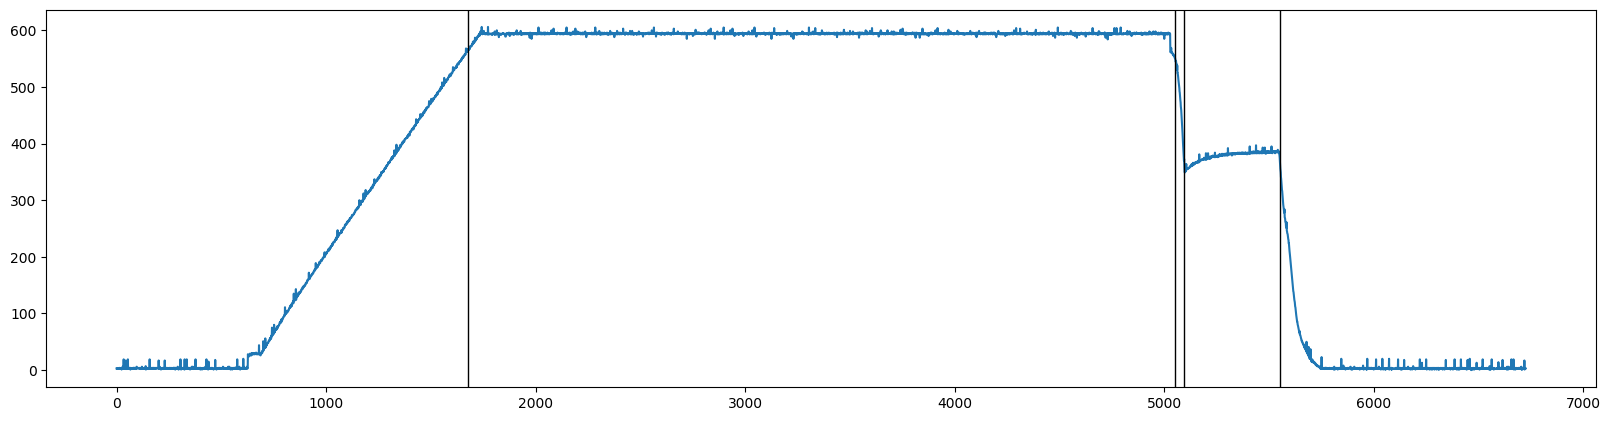

KeyboardInterrupt: 

In [76]:
processed_tank_data = remove_lines(processed_tank_data)

Same process as above but with function "add_lines", which adds values to the list of "peaks" according to user input.

[array([0]), array([1676]), array([5042]), array([5095]), array([5552])]


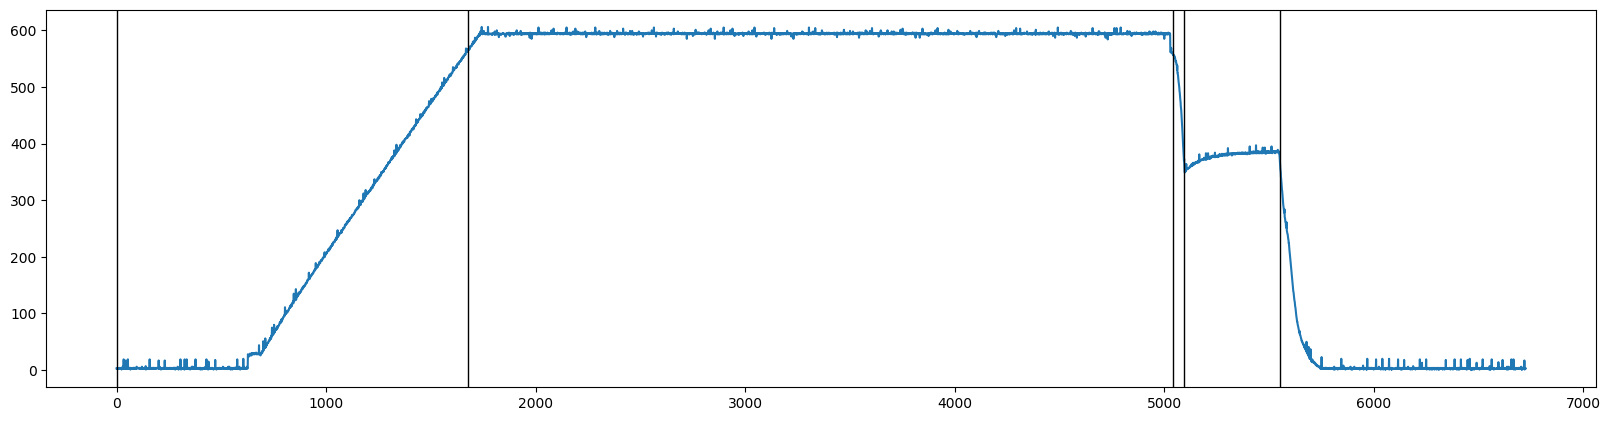

List of lines to add, by approximate X axis value (can edit later for precision):5020
[array([0]), array([1676]), array([5020]), array([5042]), array([5095]), array([5552])]


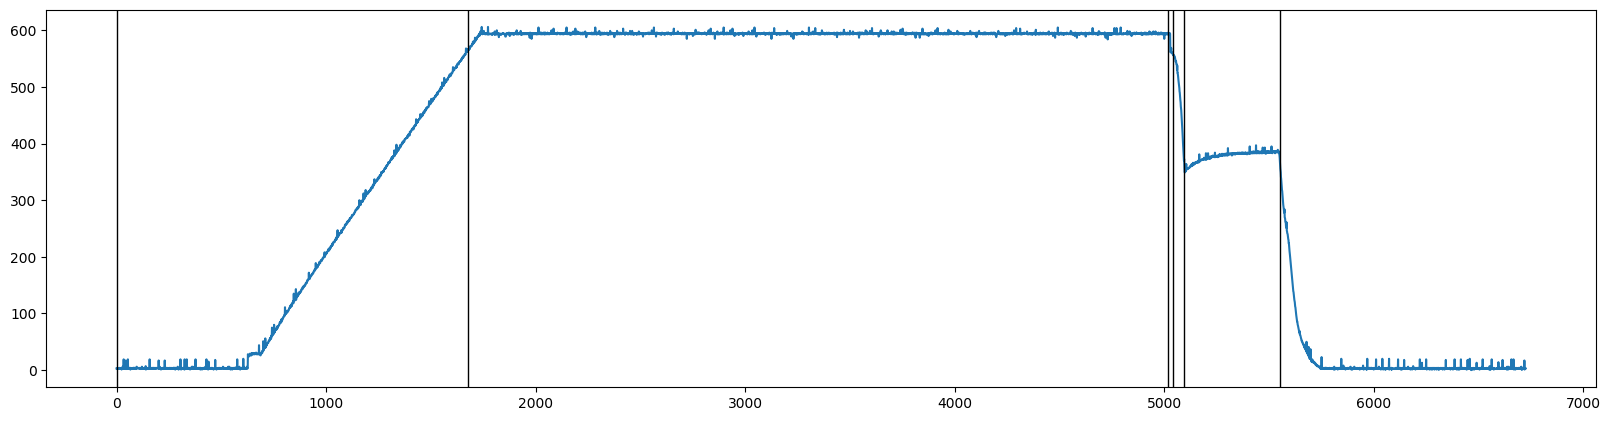

In [34]:
processed_tank_data = add_lines(processed_tank_data)

Same process as above but with function "edit_lines", which moves existing lines to new positions based on user input.

[array([1700]), array([5052]), array([5095]), array([5552])]


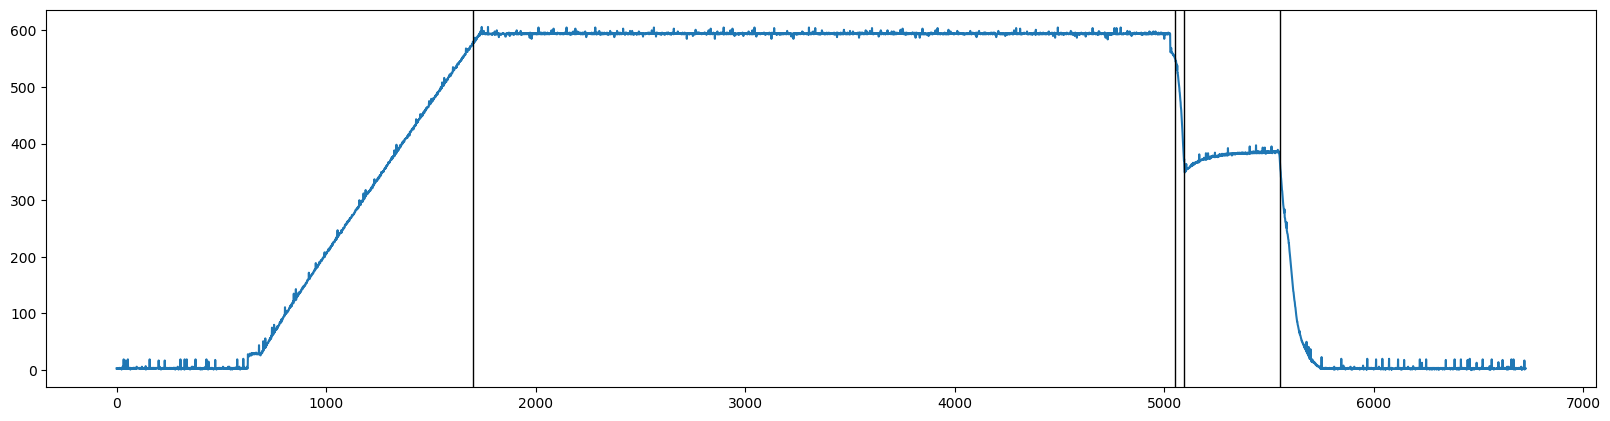

List of lines to edit, separated by comma (starting at index 0), e.g. 0,2,5: 1
Y axis value Corresponding Pressure
[5047] 555.0
[5048] 555.0
[5049] 555.0
[5050] 554.0
[5051] 551.0
Current Line:
[5052] 552.0
[5053] 550.0
[5054] 549.0
[5055] 547.0
[5056] 544.0
[5057] 546.0
Choose X value for new line or type 0 to delete5020
[array([1700]), array([5020]), array([5095]), array([5552])]


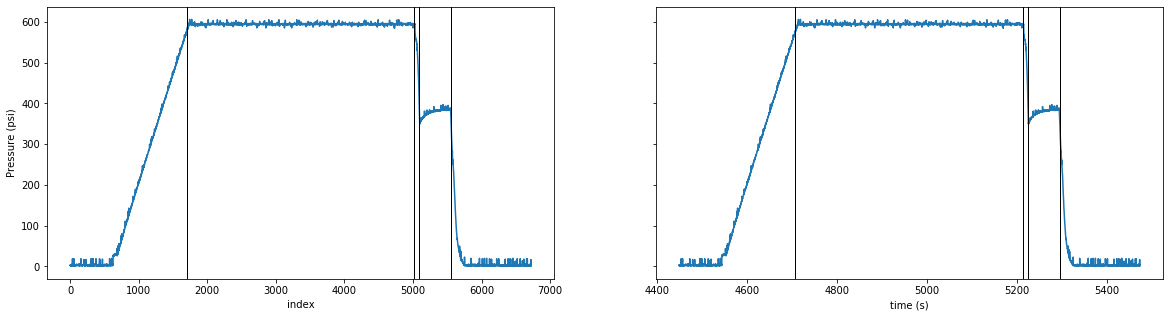

In [78]:
processed_tank_data = edit_lines(processed_tank_data)

Once data manipulation is complete, running the function "values" with the most recent data as the input returns different values depending on what data type is being passed in (to be specified through user input).  In this case, since the data is propane tank data, the function returns 5 values: static pressure (sp), dynamic pressure (dp), droop, emptying time (et), and dynamic rate of increase (ROI), respectively.  

[array([1700]), array([5020]), array([5095]), array([5552])]


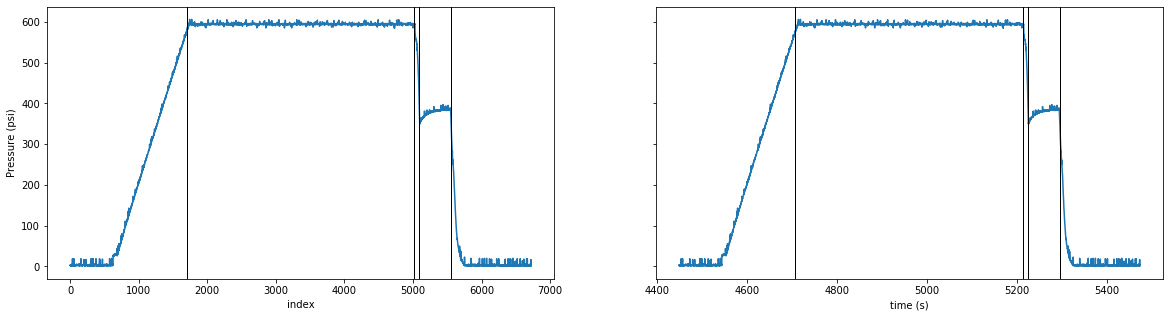

Data Type (high, propane injector, propane tank, lox injector, or lox tank)propane tank
Static Pressure: 594.2072289156627
Dynamic Pressure: 522.0666666666667
Droop: 72.14056224899593
Emptying Time: 532
Dyanmic Rate of Increase: 0.009398496240601503


In [81]:
tank_sp, tank_dp, tank_droop, tank_et, tank_dROI = values(processed_tank_data)